In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")

## Carga de datos

In [2]:
df = pd.read_csv("dataset_Caso_1.csv")

## Analisis Exploratorio

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   x3      2000 non-null   object 
 3   x4      2000 non-null   object 
 4   x5      2000 non-null   int64  
 5   x6      2000 non-null   int64  
 6   x7      2000 non-null   int64  
 7   x8      2000 non-null   float64
 8   target  2000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 140.8+ KB


In [4]:
df = df.drop_duplicates()

In [5]:
### Primero empezamos con las variables categoricas
df['x3'].value_counts()

x3
LCV    914
SAT    571
XJB    279
QKP     79
Name: count, dtype: int64

In [6]:
df['x4'].value_counts()

x4
MZBER    1761
YEQA       41
PQKE       36
ZUQF        5
Name: count, dtype: int64

In [7]:
label_encoder1, label_encoder2 = LabelEncoder(), LabelEncoder()
df['x3_new'] = label_encoder1.fit_transform(df['x3'])
df['x4_new'] = label_encoder2.fit_transform(df['x4'])

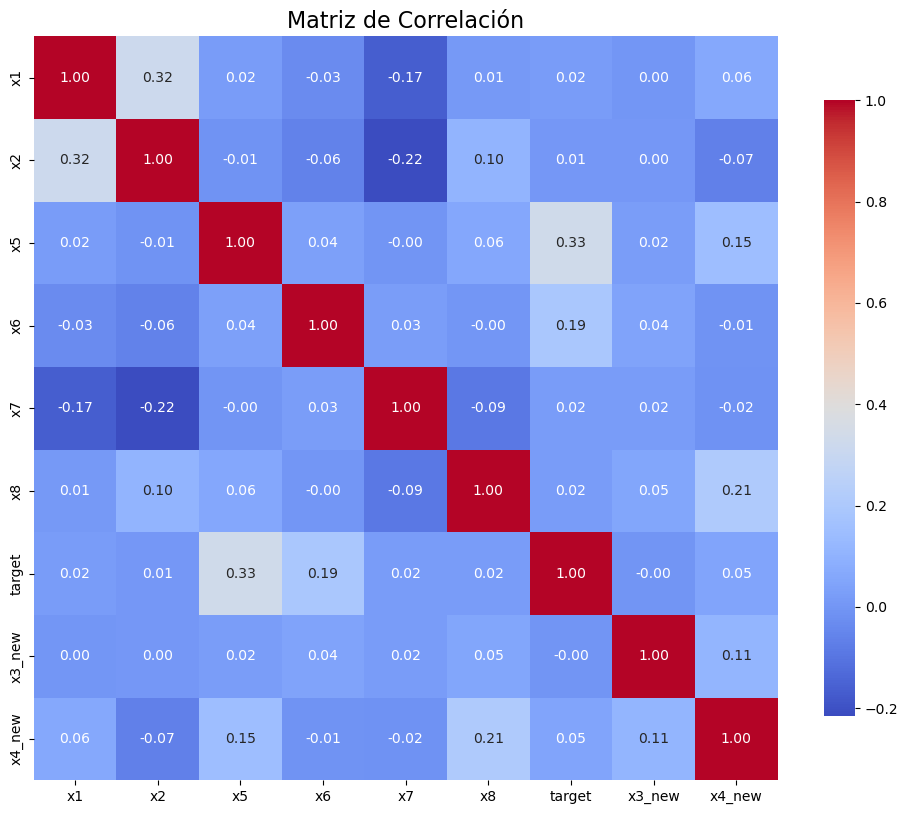

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop(['x3', 'x4'], axis=1).corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación', fontsize=16)
plt.show()
## no existe una multicolianidad entre las variables

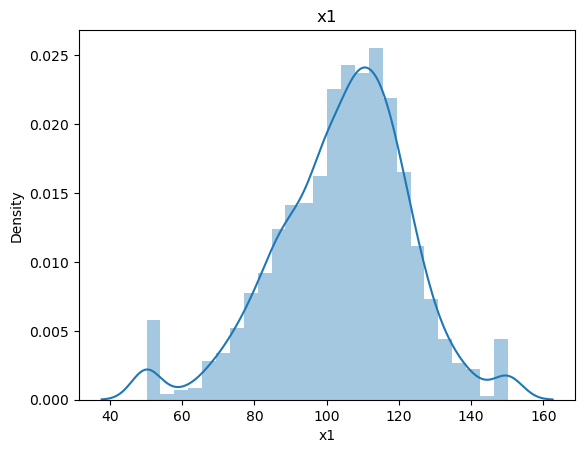

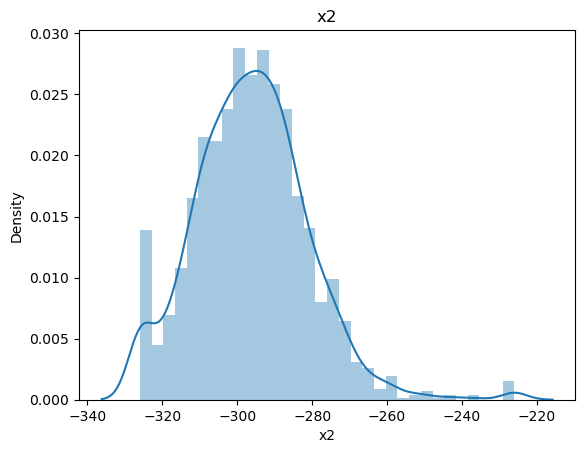

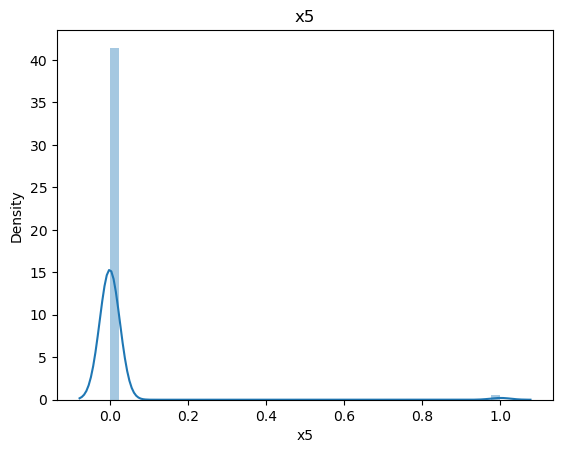

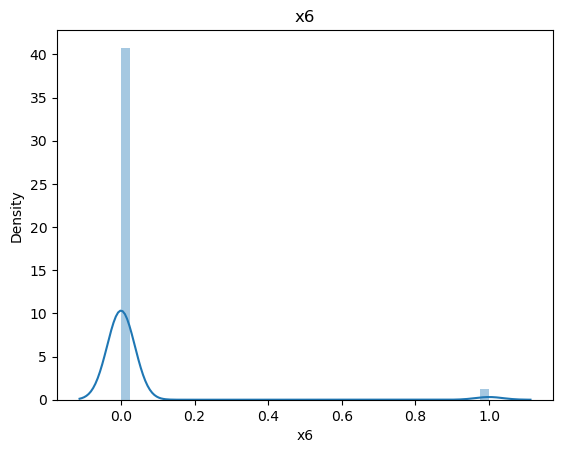

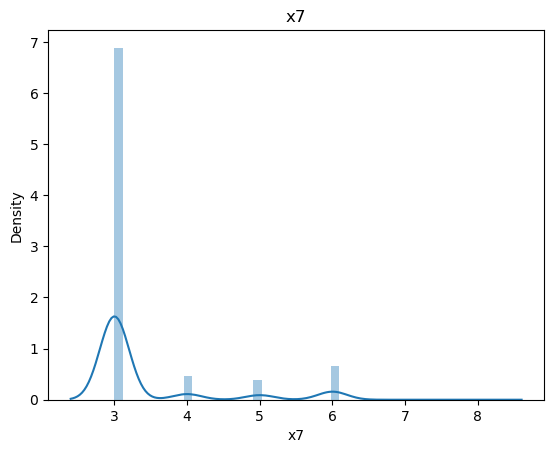

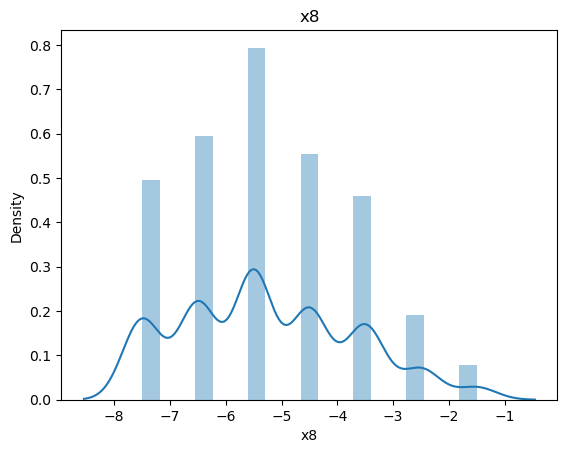

In [9]:
## Ahora visualizamos las variables numericas, en caso de ser necesario se debe realizar un escalamiento o normalización de los datos
numericas = ['x1', 'x2', 'x5', 'x6', 'x7', 'x8']
for col in numericas:
    plt.title(col)
    sns.distplot(df[col])
    plt.show()
    

In [10]:
## realizamos prueba de kolmogorov 
for col in numericas:
    if stats.kstest(df[col], 'norm').pvalue < 0.05:
        print('Los datos de '+col+ ' no tienen una distribución normal')

Los datos de x1 no tienen una distribución normal
Los datos de x2 no tienen una distribución normal
Los datos de x5 no tienen una distribución normal
Los datos de x6 no tienen una distribución normal
Los datos de x7 no tienen una distribución normal
Los datos de x8 no tienen una distribución normal


 Al descartar normalidad en las variables mediante pruebas de hipotesis, y al existir una clara diferencia en 
la escala de las variables se prosigue a normalizar u escalar

In [11]:
standar_scaler = StandardScaler()
nuevas_variables_numericas = [x+'_new' for x in numericas]
df[nuevas_variables_numericas] = standar_scaler.fit_transform(df[numericas])


Text(0.5, 1.0, 'Distribución de Variable Objetivo')

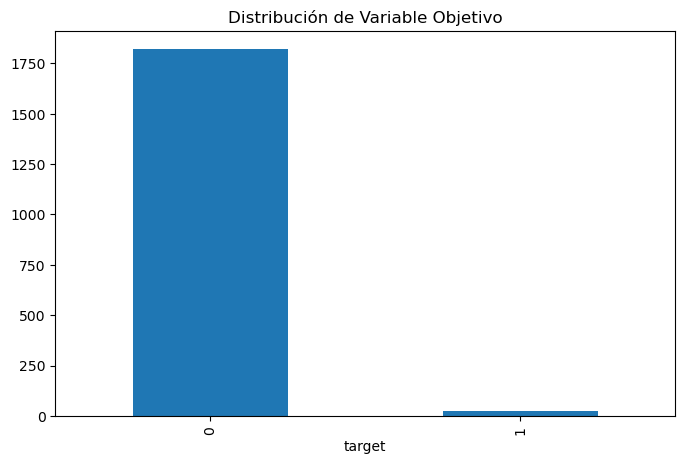

In [12]:
#Estudiamos la variable objetivo
plt.figure(figsize = (8, 5))
df['target'].value_counts().plot.bar()
plt.title('Distribución de Variable Objetivo')

In [13]:
variables_nuevas = ['x'+str(x+1)+'_new' for x in range(8)]
X = df[variables_nuevas]
y = df['target']

In [14]:
## Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 13, stratify = y)

In [15]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

<Axes: title={'center': 'Variable objetivo balanceada'}, xlabel='target'>

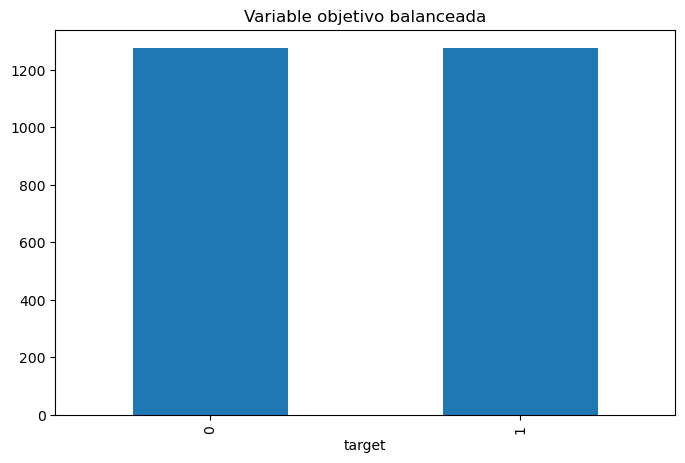

In [16]:
plt.figure(figsize = (8, 5))
plt.title('Variable objetivo balanceada')
y_train_resampled.value_counts().plot.bar()

In [17]:
## Entrenamos los datos usando xgboost
xgb_ = xgb.XGBClassifier(eval_metric = 'logloss',  alpha = 1, lambda_ = 1,use_label_encoder=False)

param_grid = {
    'n_estimators': [100, 250, 400, 500],
    'min_child_weight': [1, 2, 3, 4],
    'max_depth': [10, 20, 50, 100, None],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0],
  #  'reg_alpha': [0.01], 
  #  'reg_lambda': [1, 2],     
}

# Ajustar los hiperparametros del modelo con los datos balanceados

grid_search = GridSearchCV(estimator=xgb_, param_grid=param_grid, scoring='f1', cv=10, verbose=1)


grid_search.fit(X_train_resampled, y_train_resampled)
print(grid_search.best_params_)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.8}


In [18]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [19]:
## Procedemos a calcular las metricas de evaluación

y_train_prob = best_model.predict_proba(X_train_resampled)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]


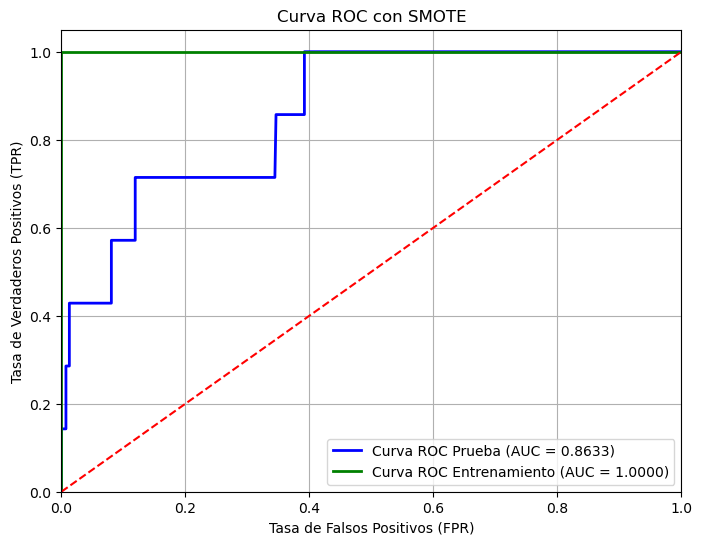

AUC para el conjunto de entrenamiento: 1.00
AUC para el conjunto de prueba: 0.86


In [20]:
#Curva ROC y AUC para el conjunto de prueba y entrenamiento
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Calcular la curva ROC y AUC para el conjunto de entrenamiento
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_resampled, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Curva ROC Prueba (AUC = {:.4f})'.format(roc_auc_test))
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='Curva ROC Entrenamiento (AUC = {:.4f})'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con SMOTE')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Imprimir AUC
print('AUC para el conjunto de entrenamiento: {:.2f}'.format(roc_auc_train))
print('AUC para el conjunto de prueba: {:.2f}'.format(roc_auc_test))

In [21]:
# Importar la función f1_score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

# Imprimir el F1 Score
print("F1 Score: {:.2f}".format(f1))

F1 Score: 0.35
